<a href="https://colab.research.google.com/github/othmanebenlamlih/PFE/blob/main/PFE_Skin_Lesionsvgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

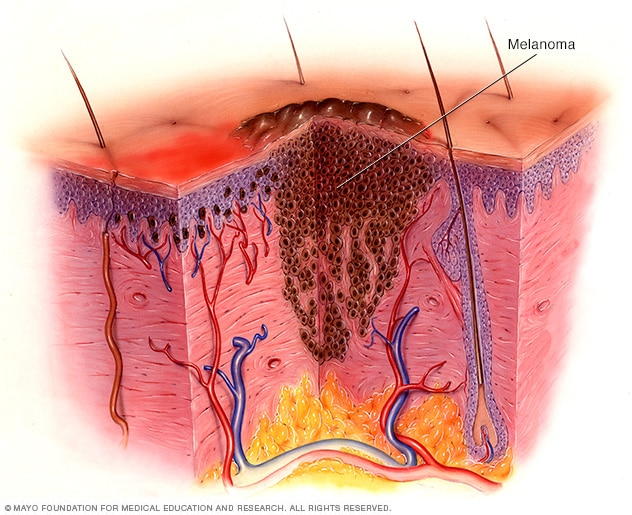

  Le cancer de la peau est une croissance anormale des cellules de la peau, c’est l’un des cancers les plus courants et malheureusement, il peut devenir mortel. La bonne nouvelle cependant, c’est que lorsqu’il est pris tôt, le dermatologue peut le traiter et l’éliminer complètement.

  Une cellule cancéreuse est maligne signifie qu’elle peut se développer et se propager à d’autres parties du corps. 
  Une cellule bénigne signifie que la tumeur peut se développer mais ne se propagera pas.

  En utilisant l’apprentissage profond et les réseaux neuronaux, nous serons en mesure de classifier les maladies cutanées bénignes et malignes, cela peut aider le médecin à diagnostiquer le cancer à un stade plus précoce.

  Dans ce travail on va essayer d'appliquer les techniques du Transfer learning, on utilisant plusieurs models pre-formés, pour avoir des modeles capable à donner une classification precises de cette maladie, en utilisant des images de la base de données ISIC.

# Classification du cancer de la peau avec les techniques de transfer learning



# Importation des bibliotheques

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook

%matplotlib inline
tf.__version__

'2.5.0'

Connexion au *Drive*

In [2]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benlamlihothmane","key":"ebc68494200b00eb5534850edcf3ab77"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 97% 314M/325M [00:08<00:00, 38.5MB/s]
100% 325M/325M [00:08<00:00, 40.5MB/s]


In [6]:
!unzip skin-cancer-malignant-vs-benign.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/train/benign/420.jpg  
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/tra

Cette fonction nous permet de telecharger les images de notre base de donnée , en les convertissant à array et en fixant leurs tailles .

In [7]:
from tqdm import tqdm
import requests
from PIL import *
import cv2 

def Dataset_loader(DIR,RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img)/255.)
    return IMG

benign_train = np.array(Dataset_loader('/content/train/benign',224))
malign_train = np.array(Dataset_loader('/content/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/test/benign',224))
malign_test = np.array(Dataset_loader('/content/test/malignant',224))

100%|██████████| 300/300 [00:00<00:00, 451.77it/s]


Dans cette etape , on donne des labels aux images du dataset, pour qu'on puisse les afficher (chaque images avec son label)

In [8]:
# Skin Cancer: Malignant vs. Benign
# Creation labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# fusion du data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Mélanger les données de l'entrainement
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]


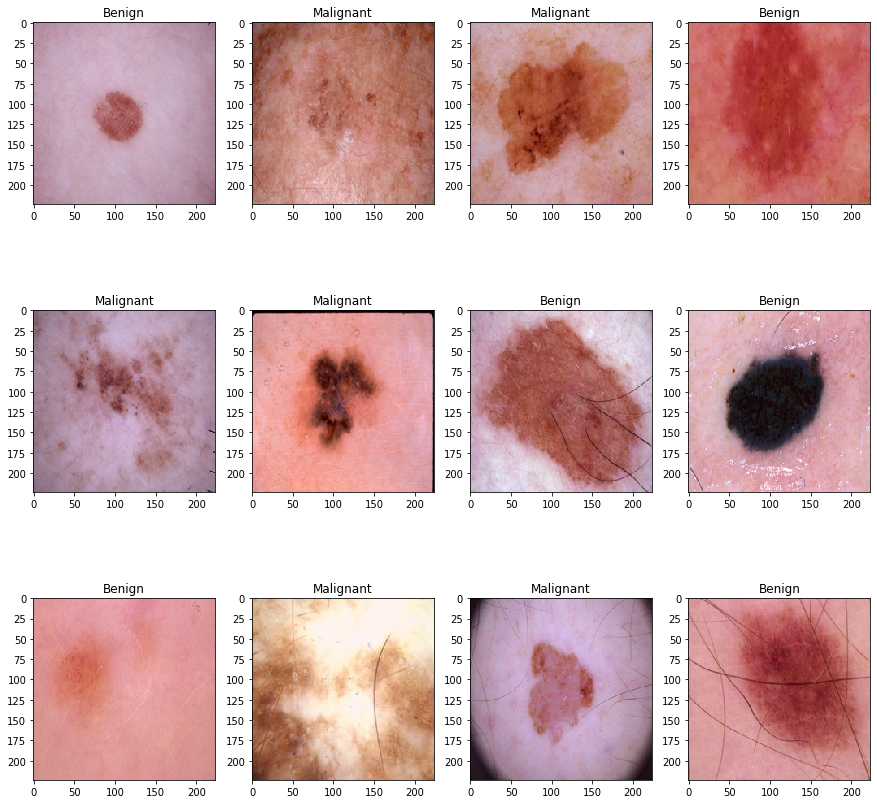

In [9]:
# Affichage des 12 premières images de taupes
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Importation des bibliotheques

In [10]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D ,BatchNormalization
from keras.optimizers import Adam , RMSprop , SGD
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from google.colab import drive 
import pandas as pd
%matplotlib inline
tf.__version__

'2.5.0'

In [11]:
#le chemin du dossier 'data' qui contient deux dossiers , 'train' et 'test'
data_path='/content/data'

In [12]:
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

In [13]:
# utile pour obtenir le nombre de classes
folders = glob(train_dir+'/*')

# Augmentation

ImageDataGenerator() est une technique d’application de différentes transformations aux images originales qui se traduit par de multiples copies transformées de la même image. Chaque copie, cependant, est différente de l’autre dans certains aspects en fonction des techniques d’augmentation que vous appliquez comme le déplacement, la rotation, le retournement, etc.

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#on a fixé le batch_size à 64 pour les images d'entrenement et du test.
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [15]:
#Tailles des images
IMG_SHAPE = (224, 224,3)

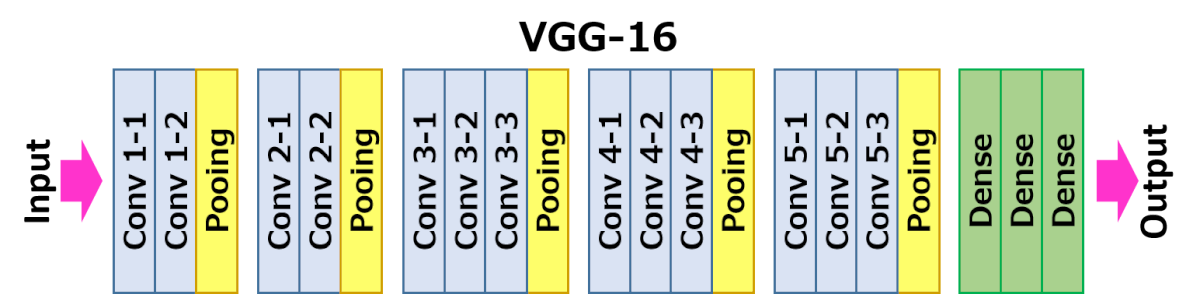

VGG16 est un modèle de réseau neuronal convolutionnel proposé par K. Simonyan et A. Zisserman de l’Université d’Oxford dans l’article « Very Deep Convolutional Networks for Large-Scale Image Recognition ». Le modèle atteint 92,7% de précision de test top-5 dans ImageNet, qui est un ensemble de données de plus de 14 millions d’images appartenant à 1000 classes. C’était l’un des fameux modèles soumis à l’ILSVRC-2014. Il améliore AlexNet en remplaçant les grands filtres de taille noyau (11 et 5 dans la première et la deuxième couche convolutionnelle, respectivement) par de multiples filtres de taille noyau 3 3 l’un après l’autre.

In [16]:
#Faire appel au model pre-definie VGG16
VGG16_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


# vgg16

## Freezing

In [17]:
VGG16_model.trainable = False

In [18]:
#ajout des couches
x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.04)(x)
predictions = Dense(len(folders), activation='softmax')(x)

In [19]:
model = Model(inputs=VGG16_model.input, outputs=predictions)

In [20]:
model.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
#Réduire le taux d’apprentissage lorsqu’une mesure cesse de s’améliorer.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
history_VGG=model.fit(training_set, epochs=50, validation_data=test_set, callbacks=[learning_rate_reduction])

Epoch 1/50
42/42 [==============================] - 115s 1s/step - loss: 0.6517 - accuracy: 0.6433 - val_loss: 0.5412 - val_accuracy: 0.8091
Epoch 2/50
42/42 [==============================] - 44s 1s/step - loss: 0.5311 - accuracy: 0.7611 - val_loss: 0.4527 - val_accuracy: 0.8045
Epoch 3/50
42/42 [==============================] - 44s 1s/step - loss: 0.4724 - accuracy: 0.7900 - val_loss: 0.4263 - val_accuracy: 0.8167
Epoch 4/50
42/42 [==============================] - 44s 1s/step - loss: 0.4376 - accuracy: 0.7999 - val_loss: 0.4059 - val_accuracy: 0.8242
Epoch 5/50
42/42 [==============================] - 44s 1s/step - loss: 0.4216 - accuracy: 0.8224 - val_loss: 0.3911 - val_accuracy: 0.8242
Epoch 6/50
42/42 [==============================] - 46s 1s/step - loss: 0.4054 - accuracy: 0.8149 - val_loss: 0.3838 - val_accuracy: 0.8364
Epoch 7/50
42/42 [==============================] - 45s 1s/step - loss: 0.4206 - accuracy: 0.8010 - val_loss: 0.3807 - val_accuracy: 0.8409
Epoch 8/50
42/42 [=

## Plot

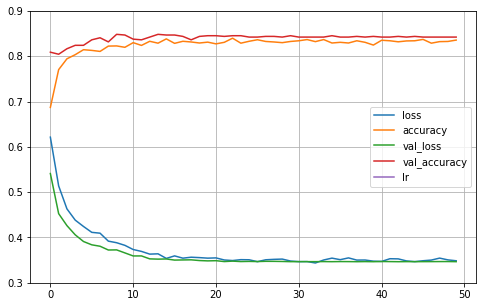

In [23]:
#affichage des resultats
pd.DataFrame(history_VGG.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 0.9)
plt.show()

## Fine-tuning

In [24]:
#unfreeze
VGG16_model.trainable = True

In [25]:
model.compile(  loss='binary_crossentropy',
  optimizer= SGD(lr=0.00001, momentum=0.9),
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
#entrainemt apres unfreeze
fine_tuning = model.fit(training_set, epochs=5, validation_data=test_set,callbacks=[learning_rate_reduction])

Epoch 1/5
42/42 [==============================] - 83s 2s/step - loss: 0.3492 - accuracy: 0.8318 - val_loss: 0.3400 - val_accuracy: 0.8500
Epoch 2/5
42/42 [==============================] - 71s 2s/step - loss: 0.3348 - accuracy: 0.8493 - val_loss: 0.3568 - val_accuracy: 0.8394
Epoch 3/5
42/42 [==============================] - 70s 2s/step - loss: 0.3422 - accuracy: 0.8357 - val_loss: 0.3396 - val_accuracy: 0.8424
Epoch 4/5
42/42 [==============================] - 71s 2s/step - loss: 0.3344 - accuracy: 0.8419 - val_loss: 0.3389 - val_accuracy: 0.8409
Epoch 5/5
42/42 [==============================] - 70s 2s/step - loss: 0.3462 - accuracy: 0.8314 - val_loss: 0.3390 - val_accuracy: 0.8424


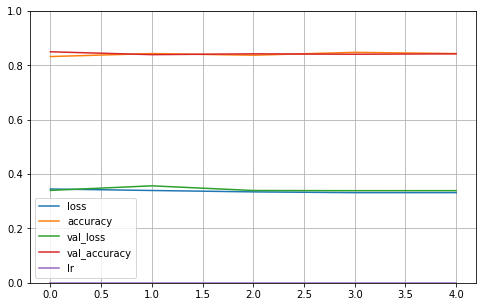

In [27]:
pd.DataFrame(fine_tuning.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

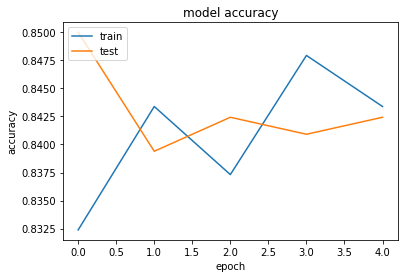

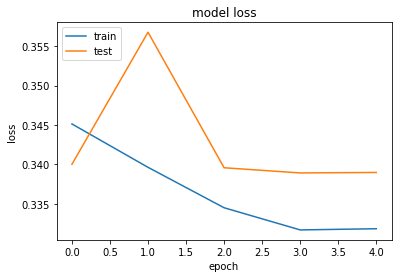

In [30]:
# Save Model and Weights
model.save('vgg16.h5')
model.save_weights('vgg16.hdf5')

In [31]:
# Load saved model
model_vgg16 = load_model('vgg16.h5')

In [32]:
y_pred = model_vgg16.predict(X_test, batch_size=1)

In [38]:
y_pred[1]

array([0.99845684, 0.00154315], dtype=float32)

In [36]:
Y_test[0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

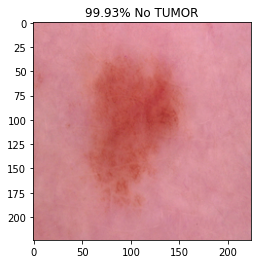

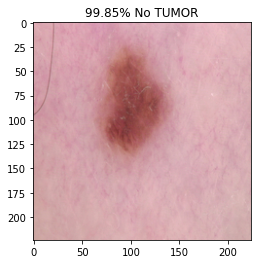

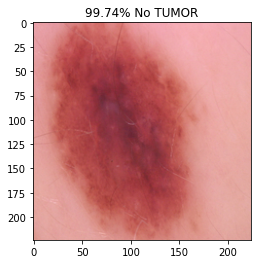

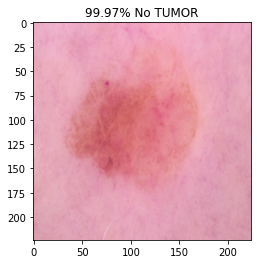

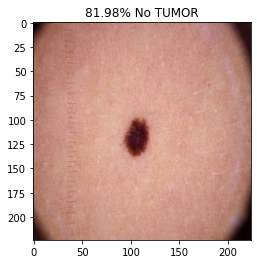

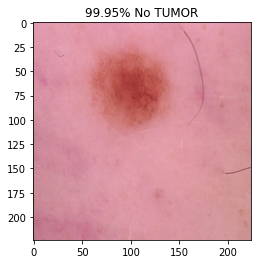

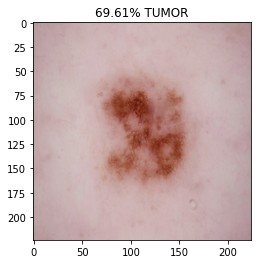

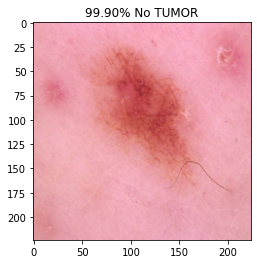

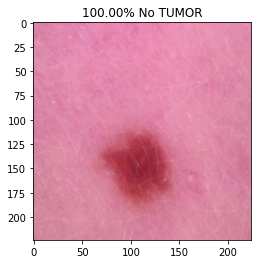

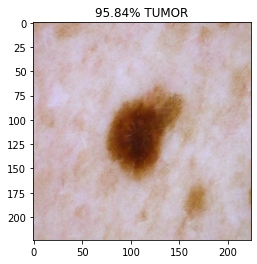

In [34]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.imshow(X_test[index])
  plt.show()